 make some mock square gauge images from rectangular gauge block images


In [34]:
from PIL import Image, ImageDraw, ImageFilter
import numpy as np
import matplotlib.pyplot as plt

In [35]:
from ls_fringeapp import fringeprocess as fp
from ls_fringeapp.load_equipment_data import repo_folder

In [56]:
from plot_helpers import draw_gauge, affine_coeffs

In [37]:
out_image_folder = repo_folder / "tests" / "data" / "mock_square_gauges"
to_process = repo_folder / "tests" / "data" / "Platen03" / "cropped" / "fflog.txt"

In [38]:
d2 = np.genfromtxt(
    to_process,
    delimiter="\t",
    dtype=None,
    usecols=(0, 1, 2, 3, 4, 5, 6, 7),
    unpack=True,
)
ffracs = np.array(d2[0])
fns = d2[1]
xys = np.array(d2[2:8]).T

ffracs[0], fns[0], xys[0]


(np.float64(0.256637),
 np.str_('MSL-03_01-G.bmp'),
 array([   7.8047,  109.37  , 1023.7   ,  178.58  ,  996.06  ,  413.88  ]))

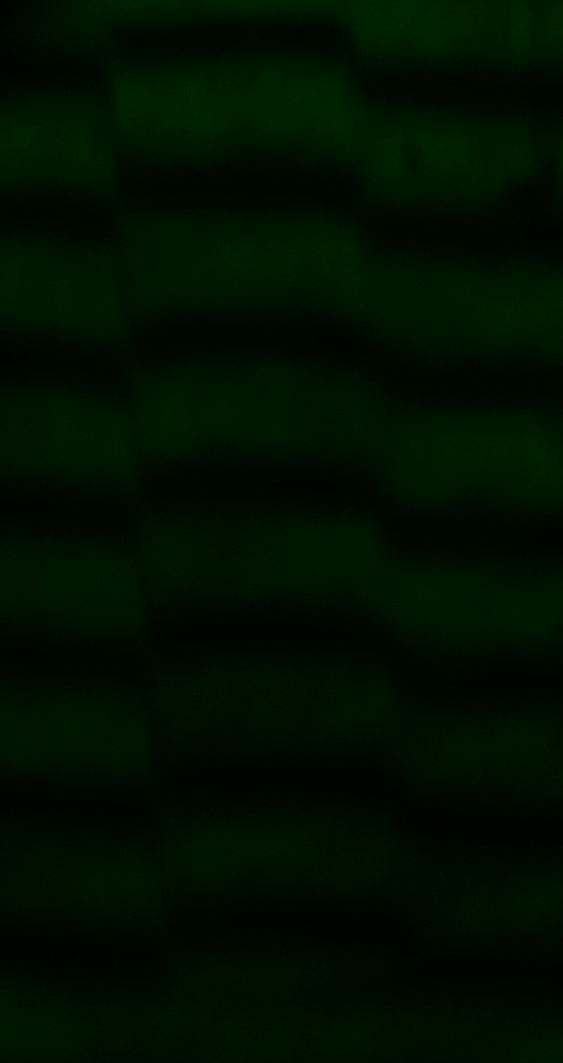

In [39]:
index = 0
img_filename = to_process.parent / fns[index]
img = Image.open(img_filename)
img

In [40]:
type(img)

PIL.BmpImagePlugin.BmpImageFile

In [41]:
f"{img.size=}"

'img.size=(563, 1063)'

In [42]:
xygb = xys[index].reshape((3, 2))
xygb

array([[   7.8047,  109.37  ],
       [1023.7   ,  178.58  ],
       [ 996.06  ,  413.88  ]])

In [43]:
img = img.convert("L")
img_array = np.asarray(img)
img_array.shape

(1063, 563)

In [44]:
ffrac, drawdata = fp.array2frac(img_array, xygb, drawinfo=True)
ffrac, ffracs[index]

(np.float64(0.2554363953191499), np.float64(0.256637))

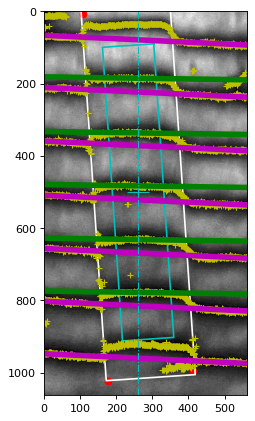

In [45]:
fig = plt.figure(figsize=(6, 6), dpi=80)
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
draw_gauge(axes, img_array, drawdata)

In [52]:
xy = xygb
xy

array([[   7.8047,  109.37  ],
       [1023.7   ,  178.58  ],
       [ 996.06  ,  413.88  ]])

In [55]:
length = ((xy[0, :] - xy[1, :]) ** 2).sum() ** 0.5
width = ((xy[1, :] - xy[2, :]) ** 2).sum() ** 0.5

dirn = (xy[2, :] - xy[1, :]) / width
xy2 = np.array(xy)  # makes a copy
xy2[2, :] = xy[2, :] + length * dirn
xy, xy2

(array([[   7.8047,  109.37  ],
        [1023.7   ,  178.58  ],
        [ 996.06  ,  413.88  ]]),
 array([[   7.8047    ,  109.37      ],
        [1023.7       ,  178.58      ],
        [ 877.26593263, 1425.17681806]]))

In [57]:
ac = affine_coeffs(xy, xy2)
ac

array([ 9.93559391e-01,  9.45381386e-02, -1.02893692e+01,  5.48290642e-02,
        1.95194500e-01,  8.75936531e+01])

In [63]:
scale = length / width
size = (int(scale * img.size[0]), img.size[1])
img_sq = img.transform(size, Image.AFFINE, ac, Image.BICUBIC)

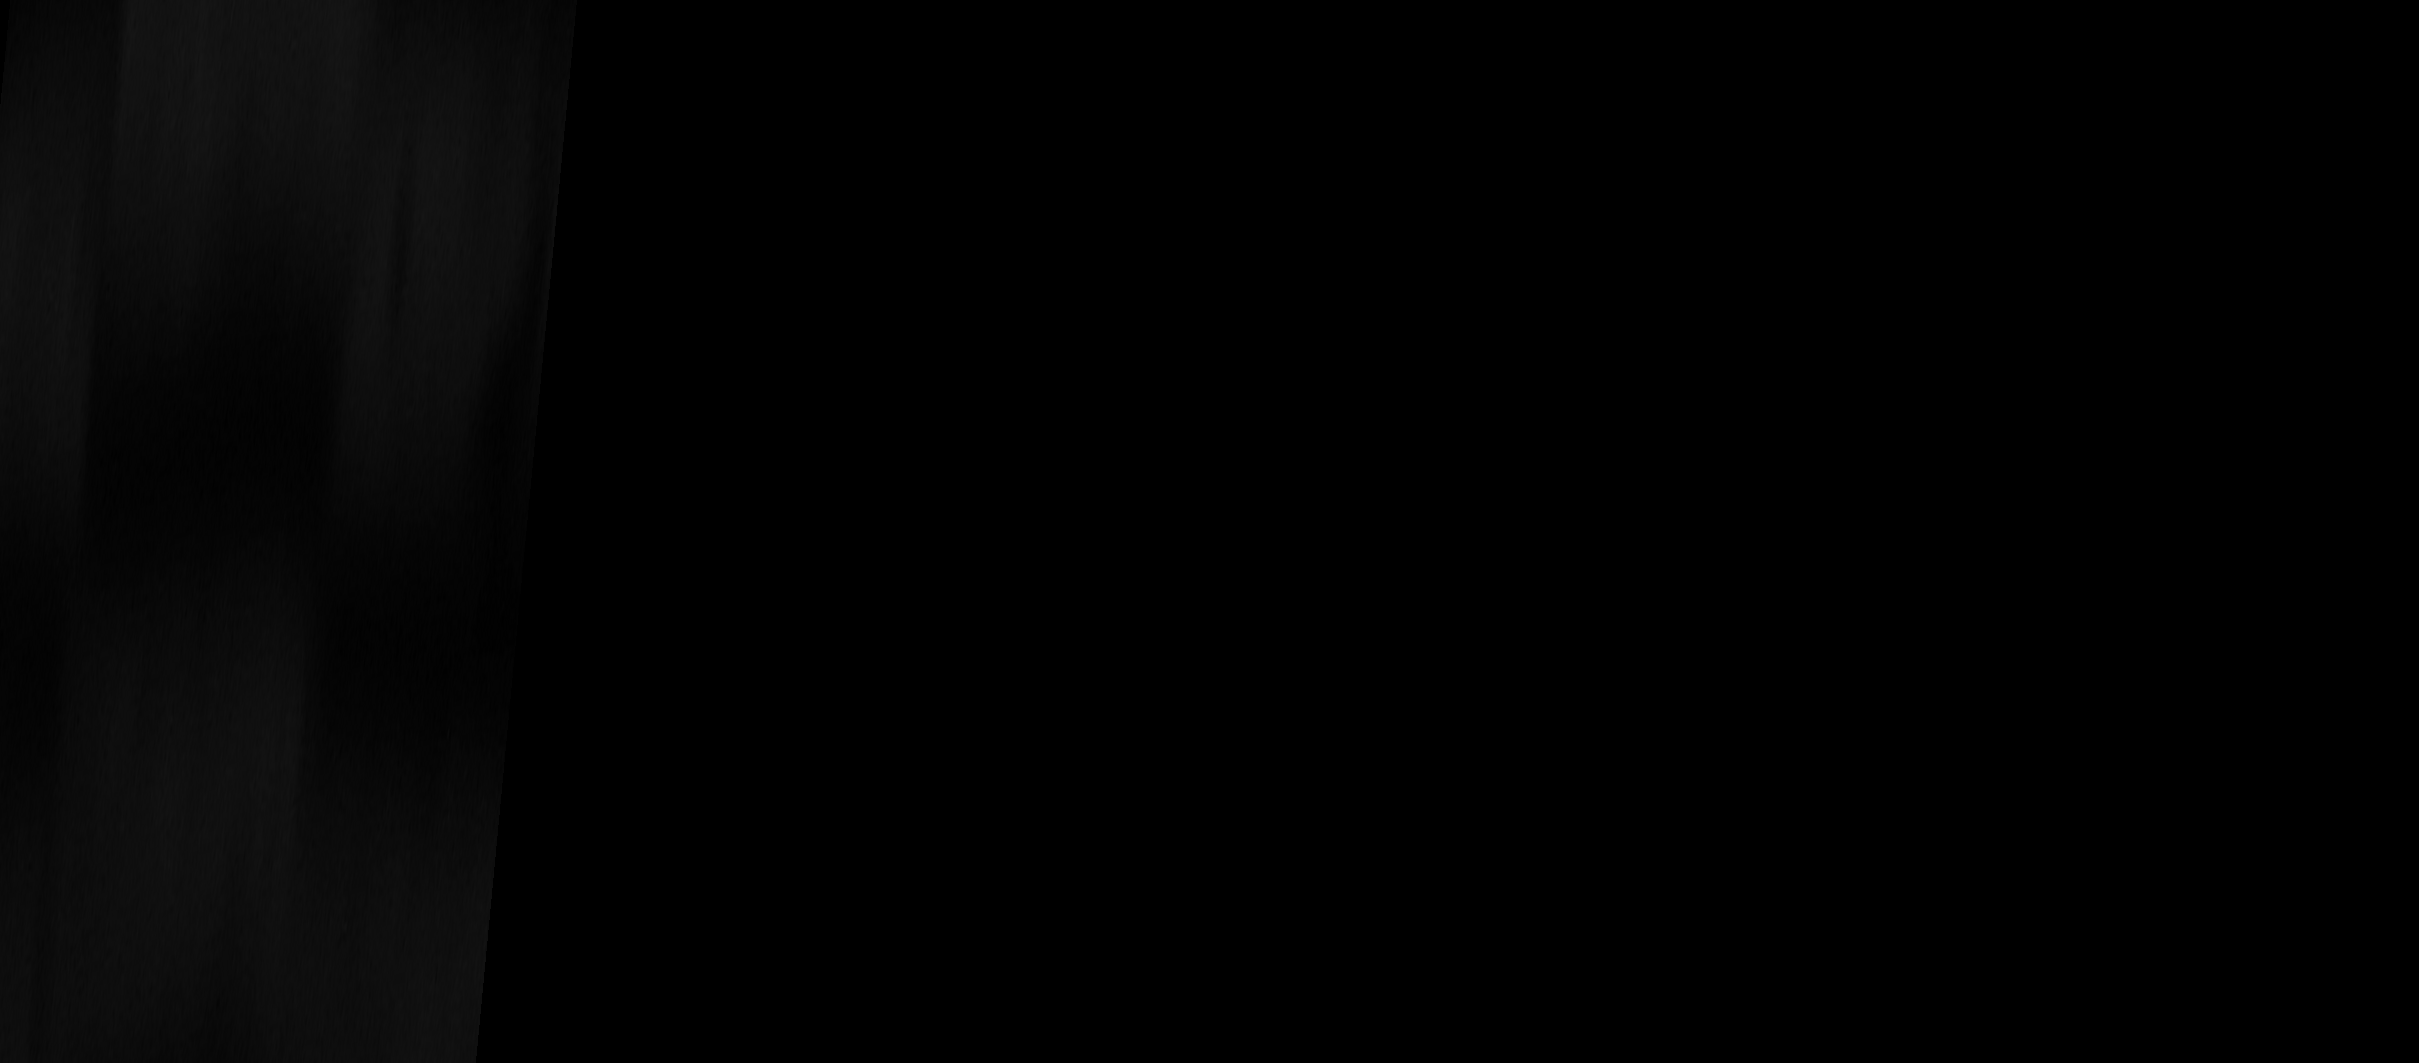

In [64]:
img_sq

In [16]:
img_array_sq = np.asarray(img_sq)
xy_sq = xy * np.array([1.0, scale])
xy, xy_sq

(array([[   7.8047,  109.37  ],
        [1023.7   ,  178.58  ],
        [ 996.06  ,  413.88  ]]),
 array([[   7.8047    ,  470.06176367],
        [1023.7       ,  767.51970153],
        [ 996.06      , 1778.81651959]]))

In [17]:
ffrac_sq, drawdata_sq = fp.array2frac(
    img_array_sq, xy_sq, drawinfo=True, border=(0.15, 0.15)
)
ffrac_sq

np.float64(0.2512414686898169)

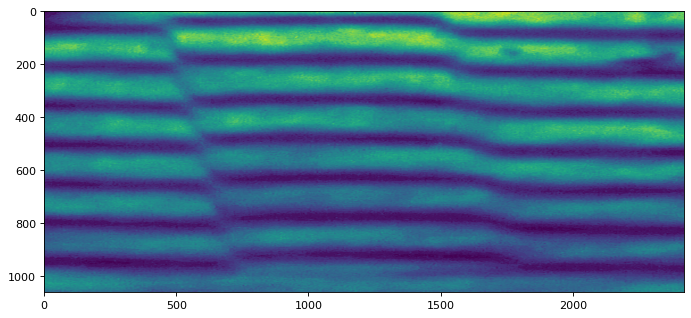

In [18]:
fig = plt.figure(figsize=(10, 6), dpi=80)
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
axes.imshow(img_array_sq)

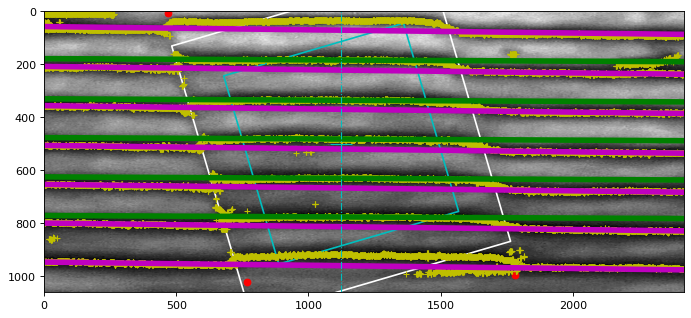

In [19]:
fig = plt.figure(figsize=(10, 6), dpi=80)
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
draw_gauge(axes, img_array_sq, drawdata_sq)

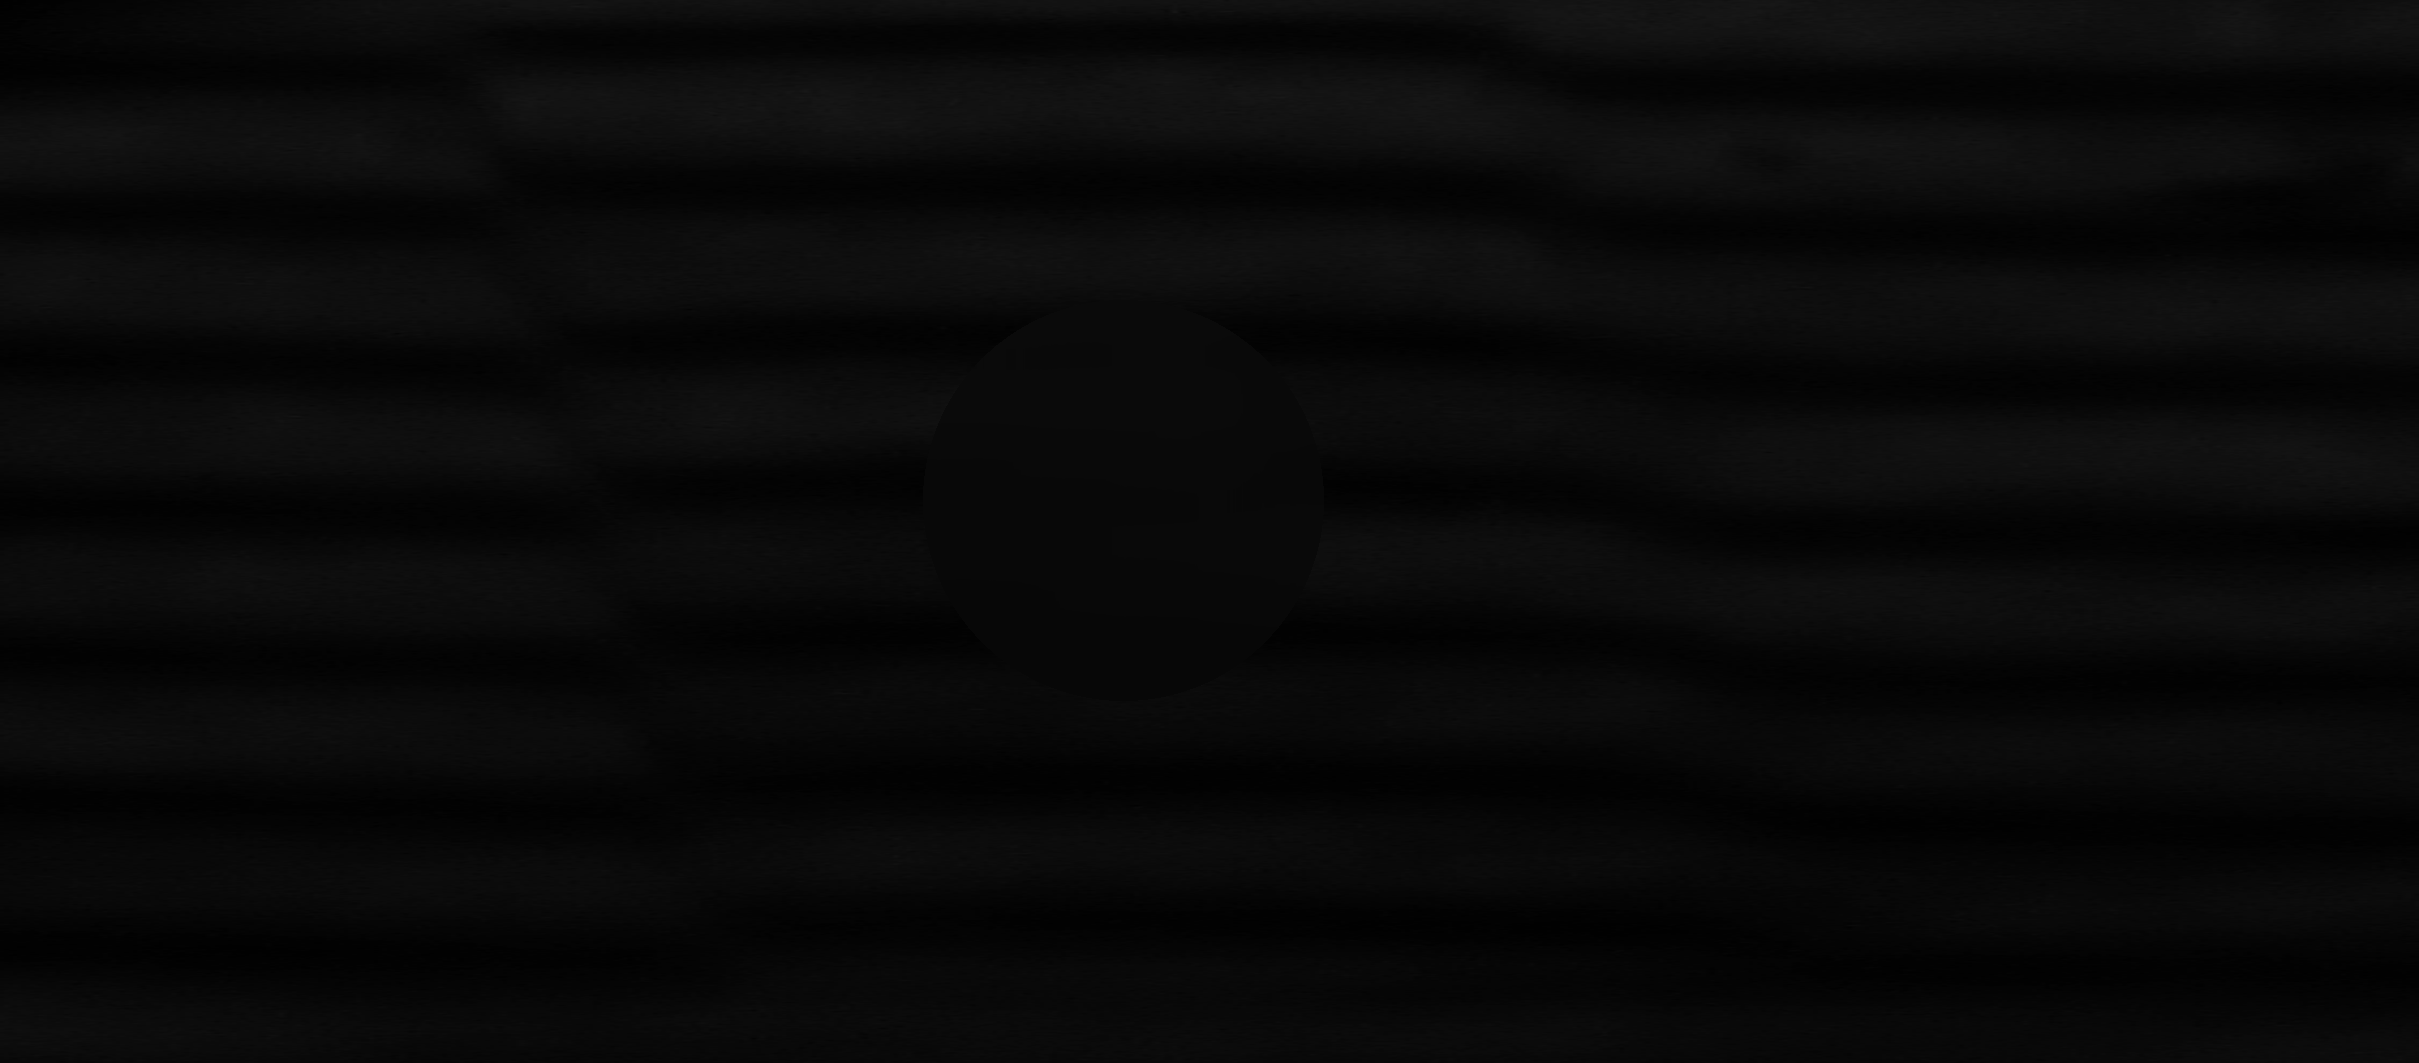

In [20]:
# blur circular area
mask = Image.new(mode="L", size=img_sq.size)
draw = ImageDraw.Draw(mask)
ccen, rcen = drawdata_sq["ccen"], drawdata_sq["rcen"]
radius_px = 200

circle = (ccen - radius_px, rcen - radius_px, ccen + radius_px, rcen + radius_px)
draw.ellipse(circle, fill="white", outline="white")
blurred = img_sq.filter(ImageFilter.GaussianBlur(50))


img_sq.paste(blurred, mask=mask)
img_sq


In [21]:
img_array_sq = np.asarray(img_sq)
ffrac_sq, drawdata_sq = fp.array2frac(
    img_array_sq,
    xy_sq,
    drawinfo=True,
    border=(0.15, 0.15),
    circle_radius=0.3,
    col_start_frac=0.05,
)
ffrac_sq

np.float64(0.23743538560238128)

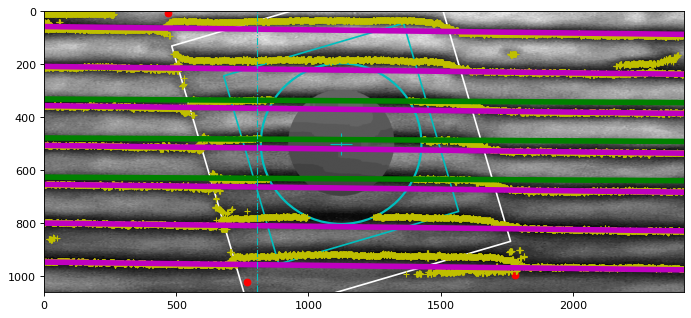

In [22]:
fig = plt.figure(figsize=(10, 6), dpi=80)
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
draw_gauge(axes, img_array_sq, drawdata_sq)

In [23]:
ffrac_sq - 0.24876325452585218

np.float64(-0.011327868923470902)

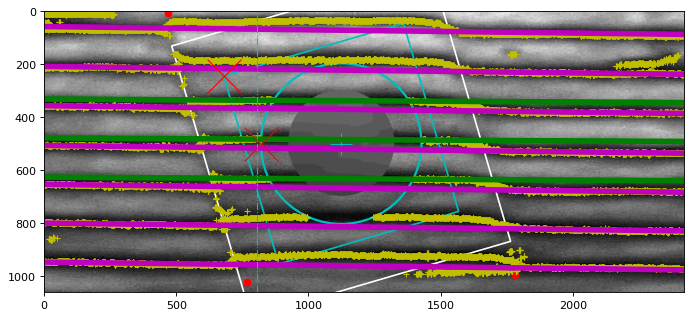

In [24]:
fig = plt.figure(figsize=(10, 6), dpi=80)
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
draw_gauge(axes, img_array_sq, drawdata_sq)
axes.plot(drawdata_sq["ci"][3], drawdata_sq["ri"][3], "xr", ms=30)

ccen, rcen = (drawdata_sq["ccen"], drawdata_sq["rcen"])
radius = drawdata_sq["circle"]
circle = (ccen - radius, rcen - radius, ccen + radius, rcen + radius)
axes.plot(circle[0], rcen, "xr", ms=30)